# Deep learning based forecasting


## Agenda

- [Deep-learning architectures review](#deep-learning-architectures-review)
- [Deep-learning repertoire in sktime](#deep-learning-repertoire-in-sktime)
    - [Using simple feed-forward networks](#using-simple-feed-forward-networks)
    - [Timeseries deep-learning architectures](#timeseries-deep-learning-architectures)
    - [Forecasting unseen timeseries](#forecasting-unseen-timeseries)
- [Conclusions](#conclusions)


## Deep-learning architectures review

Deep learning: stacking of operations that we differentiate and back-propagate.

### Feed-forward networks:

![Deep Learning images](imgs/nnetwork.png)

### Recurrent layers:

![RNN architecture](imgs/rnn.png)

* Tailored for sequential data
* The hidden state is passed from one time step to the next

![RNN and LSTM architecture](imgs/rnn_and_lstm_simplified.png)


### Attention layer:

* Not recurrent: each time step can attend to all previous time steps
* The attention mask is a proxy to importance of previous time steps
* In timeseries, the attention can only attend to previous time steps

![Attention layer](imgs/attention_layer.png)


### Main differences

| Feature                     | RNN                                       | Attention Layer                            |
|-----------------------------|-------------------------------------------|--------------------------------------------|
| Processing Style            | Sequential                                | Parallel                                    |
| Dependency Modeling         | Local (past → present)                    | Global (all → all)                          |
| Long-term Dependencies      | Hard to capture                           | Easy to capture                             |
| Training Speed              | Slower (can’t parallelize over time)      | Faster (fully parallel)                     |
| Interpretability            | Harder                                    | Easier (attention weights show importance)  |
| Memory                      | Implicit (hidden state)                   | Explicit (direct access via attention)      |


## Deep learning repertoire in sktime

![Deep learning ingredients](imgs/deep_learning_ingredients.png)

* **Be careful with the "hype"**. Deep learning methods for forecasting do not perform miracles, and they are not always the best choice. 
* If you decide to apply the methods presented in this notebook, you should **always benchmark them against traditional and simpler methods**, such as a Naive forecaster and Exponential Smoothing.

Sktime has a large repertoire of deep-learning methods. As an interface, sktime makes all python ecosystem available to you, including Pytorch-Forecasting and NeuralForecast.

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=FutureWarning)

In [39]:
# Global Deep learning methods
from sktime.forecasting.neuralforecast import (
    NeuralForecastLSTM,
    NeuralForecastDilatedRNN,
    NeuralForecastRNN,
)
from sktime.forecasting.pytorchforecasting import (
    PytorchForecastingDeepAR,
    PytorchForecastingNBeats,
    PytorchForecastingNHiTS,
    PytorchForecastingTFT,
    PytorchForecastingNHiTS,
)

from sktime.forecasting.pykan_forecaster import PyKANForecaster

# Foundational models
# We will see them in the next session
from sktime.forecasting.chronos import ChronosForecaster
from sktime.forecasting.timesfm_forecaster import TimesFMForecaster
from sktime.forecasting.moirai_forecaster import MOIRAIForecaster
from sktime.forecasting.ttm import TinyTimeMixerForecaster

# Utilities
from sktime.utils.plotting import plot_series
from sktime.split.temporal_train_test_split import temporal_train_test_split
import matplotlib.pyplot as plt
from sktime.forecasting.base import ForecastingHorizon
from sklearn.preprocessing import MinMaxScaler
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

msse = MeanSquaredScaledError(multilevel="uniform_average")

**The dataset**

In [3]:
import pandas as pd
from sktime.transformations.hierarchical.aggregate import Aggregator
df = pd.read_csv("https://raw.githubusercontent.com/felipeangelimvieira/prophetverse/f61e948d2840f73688570561218d2cf810a256bc/src/prophetverse/datasets/raw/tourism.csv")
df["Quarter"] = pd.to_datetime(df["Quarter"]).dt.to_period("Q")
y = df.set_index(["State", "Region", "Purpose", "Quarter"])[["Trips"]]
y = y.groupby(level=["Purpose", "State", "Quarter"]).sum()
y

Trips
Purpose  State             Quarter            
Business ACT               1998Q1   150.198117
                           1998Q2    99.932677
                           1998Q3   129.565117
                           1998Q4   101.698973
                           1999Q1    95.524910
...                                        ...
Visiting Western Australia 2015Q4   667.818035
                           2016Q1   889.717360
                           2016Q2   587.785117
                           2016Q3   662.563529
                           2016Q4   787.030391

[2128 rows x 1 columns]

In [4]:
y.index.droplevel(-1).nunique()

28

In [5]:
y.index.droplevel(-1).unique()

MultiIndex([('Business',                'ACT'),
            ('Business',    'New South Wales'),
            ('Business', 'Northern Territory'),
            ('Business',         'Queensland'),
            ('Business',    'South Australia'),
            ('Business',           'Victoria'),
            ('Business',  'Western Australia'),
            ( 'Holiday',                'ACT'),
            ( 'Holiday',    'New South Wales'),
            ( 'Holiday', 'Northern Territory'),
            ( 'Holiday',         'Queensland'),
            ( 'Holiday',    'South Australia'),
            ( 'Holiday',           'Victoria'),
            ( 'Holiday',  'Western Australia'),
            (   'Other',                'ACT'),
            (   'Other',    'New South Wales'),
            (   'Other', 'Northern Territory'),
            (   'Other',         'Queensland'),
            (   'Other',    'South Australia'),
            (   'Other',           'Victoria'),
            (   'Other',  'Western Austr

We create some exogenous variables as example:

In [6]:
from sktime.transformations.series.fourier import FourierFeatures

X = pd.DataFrame(
    index=y.index,
)

fourier_features = FourierFeatures(sp_list=[4], fourier_terms_list=[4], freq="Q")
fourier_features.fit(X)

X = fourier_features.transform(X)

X

sin_4_1       cos_4_1       sin_4_2  \
Purpose  State             Quarter                                             
Business ACT               1998Q1   0.000000e+00  1.000000e+00  0.000000e+00   
                           1998Q2   1.000000e+00  6.123234e-17  1.224647e-16   
                           1998Q3   1.224647e-16 -1.000000e+00 -2.449294e-16   
                           1998Q4  -1.000000e+00 -1.836970e-16  3.673940e-16   
                           1999Q1  -2.449294e-16  1.000000e+00 -4.898587e-16   
...                                          ...           ...           ...   
Visiting Western Australia 2015Q4  -1.000000e+00  9.815744e-16 -1.963149e-15   
                           2016Q1  -4.408728e-15  1.000000e+00 -8.817457e-15   
                           2016Q2   1.000000e+00  9.799031e-15  1.959806e-14   
                           2016Q3   9.784795e-16 -1.000000e+00 -1.956959e-15   
                           2016Q4  -1.000000e+00 -6.368782e-15  1.273756e-14   

                                    cos_4_2       sin_4_3       cos_4_3  \
Purpose  State             Quarter                                        
Business ACT               1998Q1       1.0  0.000000e+00  1.000000e+00   
                           1998Q2      -1.0 -1.000000e+00 -1.836970e-16   
                           1998Q3       1.0  3.673940e-16 -1.000000e+00   
                           1998Q4      -1.0  1.000000e+00  5.510911e-16   
                           1999Q1       1.0 -7.347881e-16  1.000000e+00   
...                                     ...           ...           ...   
Visiting Western Australia 2015Q4      -1.0  1.000000e+00  1.126613e-14   
                           2016Q1       1.0 -2.743704e-14  1.000000e+00   
                           2016Q2      -1.0 -1.000000e+00  1.323547e-14   
                           2016Q3       1.0  2.935438e-15 -1.000000e+00   
                           2016Q4      -1.0  1.000000e+00  1.910635e-14   

                                         sin_4_4  cos_4_4  
Purpose  State             Quarter                         
Business ACT               1998Q1   0.000000e+00      1.0  
                           1998Q2  -2.449294e-16      1.0  
                           1998Q3  -4.898587e-16      1.0  
                           1998Q4  -7.347881e-16      1.0  
                           1999Q1  -9.797174e-16      1.0  
...                                          ...      ...  
Visiting Western Australia 2015Q4   3.926298e-15      1.0  
                           2016Q1  -1.763491e-14      1.0  
                           2016Q2  -3.919613e-14      1.0  
                           2016Q3  -3.913918e-15      1.0  
                           2016Q4  -2.547513e-14      1.0  

[2128 rows x 8 columns]

**Split & visualize**

In [7]:
# Splitting the data
TEST_SIZE = 15
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=TEST_SIZE)

fh = ForecastingHorizon(range(1, TEST_SIZE + 1), is_relative=True)

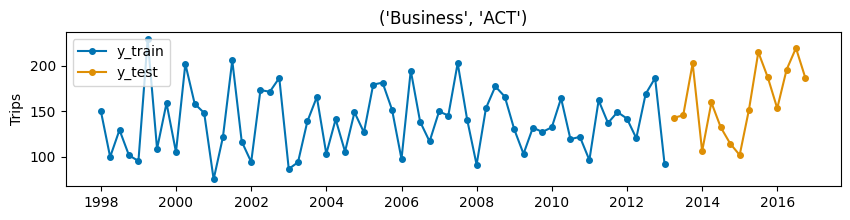

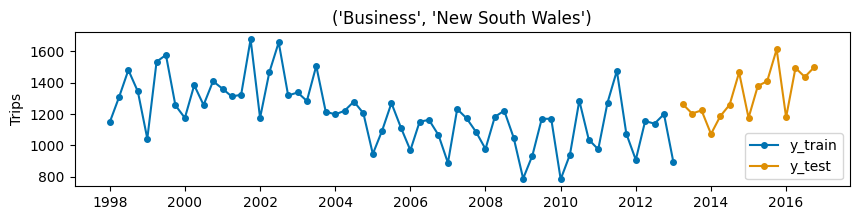

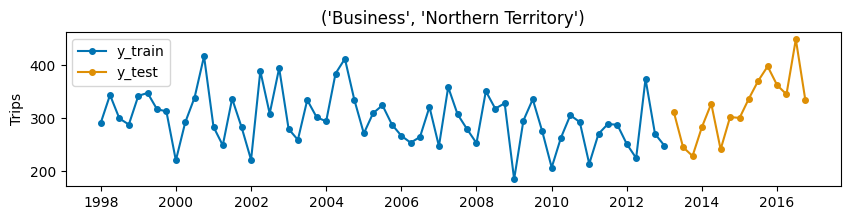

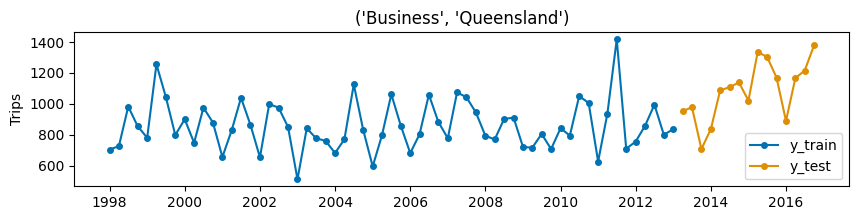

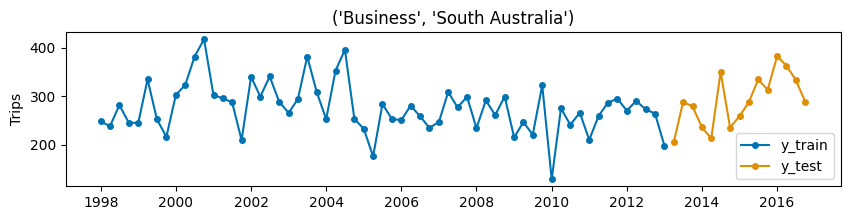

In [8]:
def plot_series_and_forecast(forecasts=[], labels=[], **kwargs):
    unique_series = y.index.droplevel(-1).unique()
    series_to_plot = unique_series[:5]


    for series in series_to_plot:
        fig, ax = plt.subplots(1, figsize=(10, 2))
        forecasts_to_plot = [forecast.loc[series] for forecast in forecasts]
        plot_series(y_train.loc[series], 
                    y_test.loc[series],
                     *forecasts_to_plot,
                    labels=["y_train", "y_test"] + labels,
                    ax=ax,
                    **kwargs)
        
        ax.set(title=series)
        fig.show()
plot_series_and_forecast()

### Using simple feed-forward networks

As we have seen in previous notebooks, we can convert forecasting problems into regression, and use regression algorithms to forecast. Below, we will see how to use a CNNRegressor to forecast a univariate time series.

In [9]:
from sklearn.neural_network import MLPRegressor
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.difference import Differencer


# MLP Regressor

forecaster_mlp = Differencer() * make_reduction(
    MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000),
    strategy="recursive",
    window_length=10,
)
forecaster_mlp.fit(y=y_train, X=X_train)
y_pred_mlp = forecaster_mlp.predict(fh=fh, X=X_test)

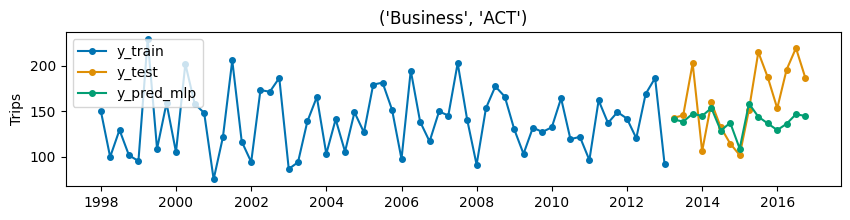

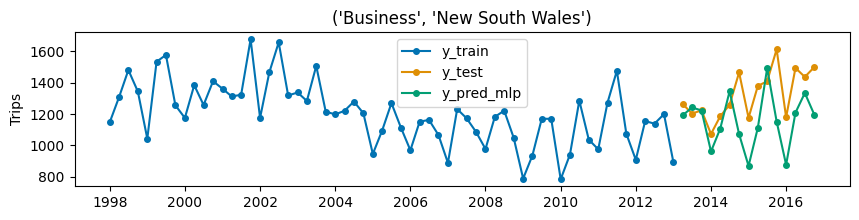

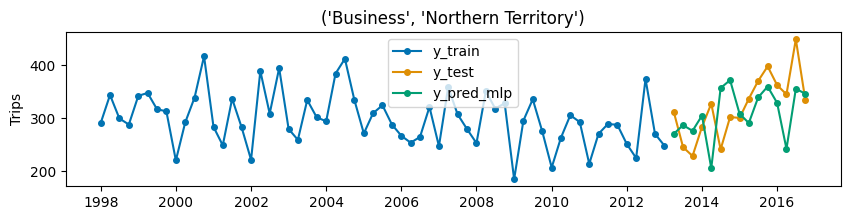

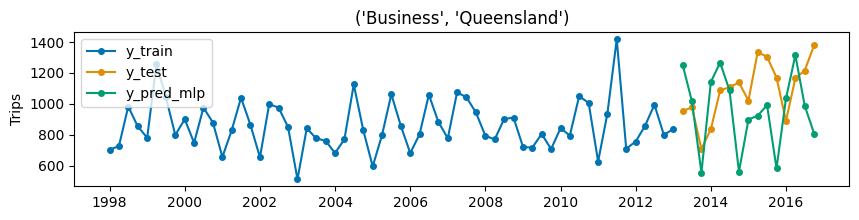

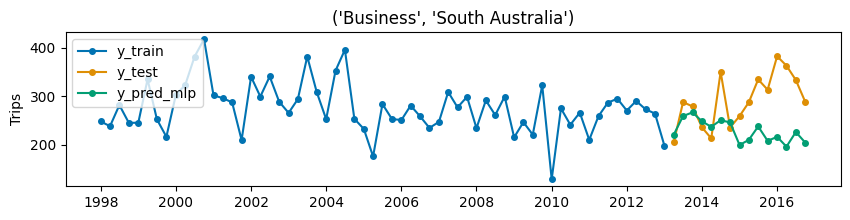

In [10]:
plot_series_and_forecast([y_pred_mlp], ["y_pred_mlp"])

In [40]:
msse(
    y_test,
    y_pred_mlp,
    y_train=y_train,
)

np.float64(2.178904066272213)

### Timeseries deep-learning architectures

Many deep learning architectures have been proposed for time-series forecasting. Here, we will be focusing mainly on three of them:

- **N-BEATS**: N-BEATS is a powerful and interpretable deep-learning model designed specifically for time-series forecasting. It uses a fully connected architecture with specialized blocks to model trend and seasonality components. Its interpretable stack-based architecture makes each stack responsible for a certain component , making it useful for trend and seasonality decomposition.

- **Temporal Fusion Transformer (TFT)**: TFT is a state-of-the-art architecture that combines the strengths of transformers with specialized time-series components. It is designed to handle multiple covariates and can incorporate both static and dynamic features in forecasting. The model uses attention mechanisms to focus on relevant time steps and features, enabling robust and interpretable forecasts. Additionally, TFT supports uncertainty estimation, making it well-suited for applications requiring probabilistic forecasting.

- **DeepAR**: Recurrent Neural Networks with probabilistic forecasting. 

#### N-Beats

Highlights:

* Fully connected architecture
* Can be understood as a meta-learning architecture, where coefficients are learned dynamically from inputs, before being applied to basis functions (which are static across timeseries problems).
* Can be used for interpretable trend and seasonality decomposition
* The general idea of N-Beats is to find a set of basis that can decompose the timeseries and dynamically determine the coefficients of these basis functions.


<img src="imgs/nbeats_simplified.png" alt="NBEATS" width="600"/>


* In its interpretable version, each block is responsible for a certain component (trend, seasonality, etc.). The model is trained end-to-end, and the blocks are stacked to form a deep architecture.

![Decomposition](imgs/series_decomposition.png)



In [12]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats


CONTEXT_LENGTH = 10
nbeats_forecaster = PytorchForecastingNBeats(
    
    model_params={
        "stack_types": ["trend", "seasonality"],
        "num_blocks" : [2,2],
        "context_length": CONTEXT_LENGTH,
        "expansion_coefficient_lengths" : [3, 4],
        "learning_rate": 1e-3,
    },
    dataset_params={

        "max_encoder_length": CONTEXT_LENGTH,
    },
    trainer_params={
        "max_epochs": 100
        }

)

nbeats_forecaster.fit(y_train, fh=fh)
y_pred_nbeats = nbeats_forecaster.predict(fh=fh) 

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["_target_column"].fillna(0, inplace=True)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params | 

Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 30.42it/s, v_num=237, train_loss_step=0.720, val_loss=0.819, train_loss_epoch=0.742]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 26.52it/s, v_num=237, train_loss_step=0.720, val_loss=0.819, train_loss_epoch=0.742]


/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

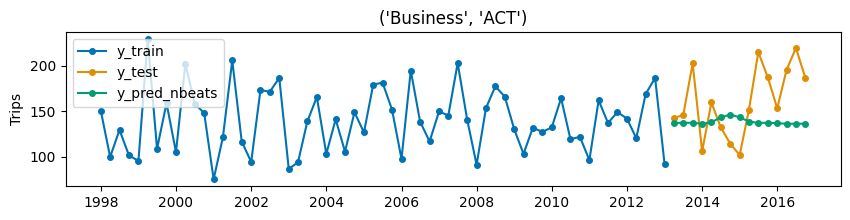

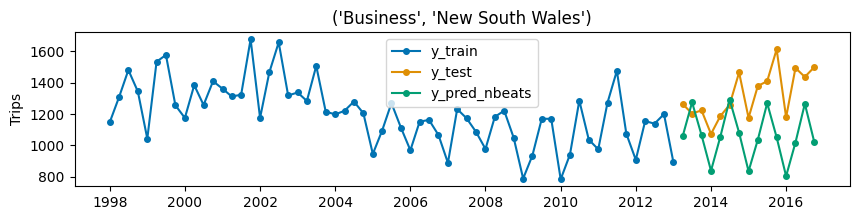

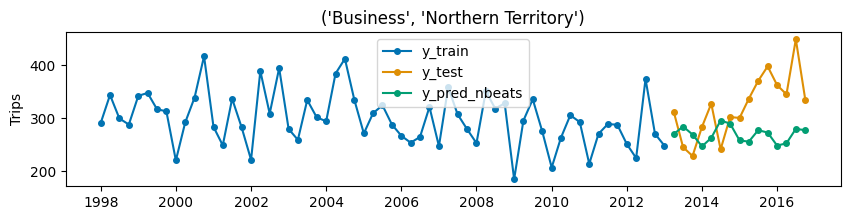

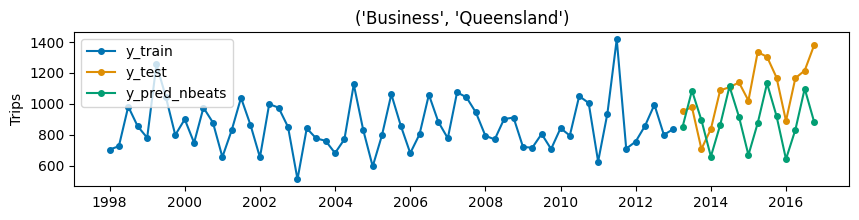

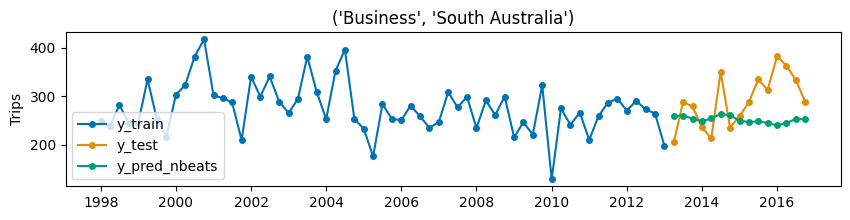

In [13]:
plot_series_and_forecast([y_pred_nbeats], ["y_pred_nbeats"])

* What if we use Differencer?

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["_target_column"].fillna(0, inplace=True)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params | 

Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 31.42it/s, v_num=239, train_loss_step=0.466, val_loss=0.573, train_loss_epoch=0.492]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 27.30it/s, v_num=239, train_loss_step=0.466, val_loss=0.573, train_loss_epoch=0.492]


/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

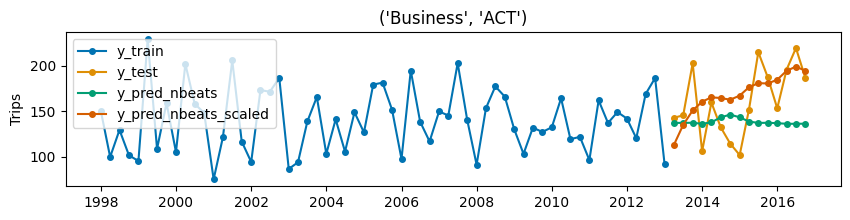

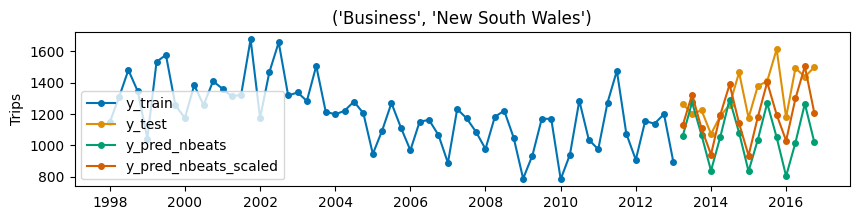

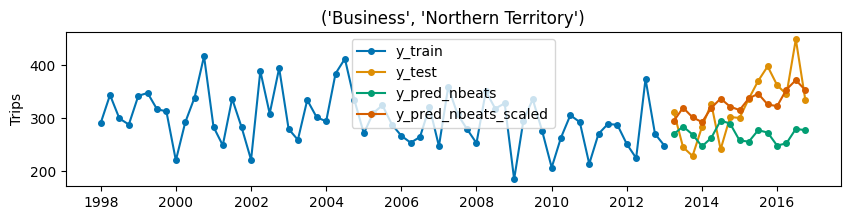

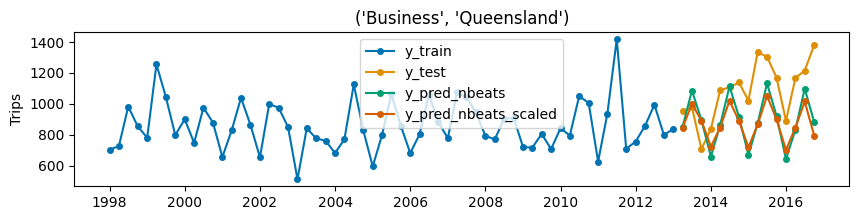

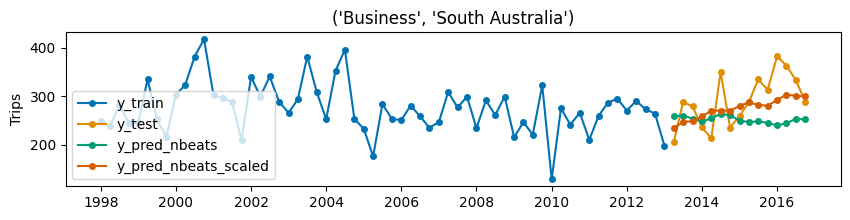

In [14]:
nbeats_differenced_forecaster = ( Differencer()) * nbeats_forecaster
nbeats_differenced_forecaster.fit(y_train, fh=fh)
y_pred_nbeats_differenced = nbeats_differenced_forecaster.predict(fh=fh)

plot_series_and_forecast([y_pred_nbeats, y_pred_nbeats_differenced], ["y_pred_nbeats", "y_pred_nbeats_scaled"])

In [41]:
print(
    f"Mean Squared Scaled Error (nbeats): {msse(y_true=y_test, y_pred=y_pred_nbeats, y_train=y_train)}",
    f"Mean Squared Scaled Error (nbeats + differencer): {msse(y_true=y_test, y_pred=y_pred_nbeats_differenced, y_train=y_train)}",
    sep="\n"
)

Mean Squared Scaled Error (nbeats): 2.223984918675981
Mean Squared Scaled Error (nbeats + differencer): 1.4181251329968994


#### Temporal Fusion Transformer (TFT)

Highlights:

* **Transformer-based architecture**, with attention mechanisms and especific layers for time-series forecasting
* Can handle multiple covariates and **static features** (such as series' metadata) to capture relationships between different time series and the covariates
* **Can handle past-observed and future-unknown covariates**! Uses LSTM encoder-decoder architectures for covariates.
* Proposes Gating Rediual Networks (GRNs) for automatic feature selection.
* Can forecast quantiles!

In [16]:

# Add the first index as a static categorical
static_categoricals = ["_index_name_0"]

# By default, pytorch-forecasting will use group-normalizer
# to normalize the target data with standardization
tft_forecaster = PytorchForecastingTFT(
    model_params={
        
        "static_categoricals": static_categoricals,
    },
    dataset_params={
        "static_categoricals": static_categoricals,
        "max_encoder_length": 10,
        "max_prediction_length": 15,

    },
    trainer_params={
        "max_epochs": 100
    },  
)


# We also create a version with differencing to see how it performs
tft_differencer_forecaster = Differencer() * tft_forecaster.clone()

In [17]:
# Basic TFT
tft_forecaster.fit(y_train, X=X_train, fh=fh)
y_pred_tft = tft_forecaster.predict(fh=fh, X=X)

# TFT with differencing
tft_differencer_forecaster.fit(y_train, X=X_train, fh=fh)
y_pred_tft_differencer = tft_differencer_forecaster.predict(fh=fh, X=X)

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["_target_column"].fillna(0, inplace=True)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                               | Ty

Epoch 99: 100%|██████████| 9/9 [00:02<00:00,  4.40it/s, v_num=241, train_loss_step=42.00, val_loss=62.30, train_loss_epoch=44.60]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s, v_num=241, train_loss_step=42.00, val_loss=62.30, train_loss_epoch=44.60]


/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

Epoch 99: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s, v_num=243, train_loss_step=36.40, val_loss=48.90, train_loss_epoch=36.40]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:01<00:00,  5.52it/s, v_num=243, train_loss_step=36.40, val_loss=48.90, train_loss_epoch=36.40]


/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

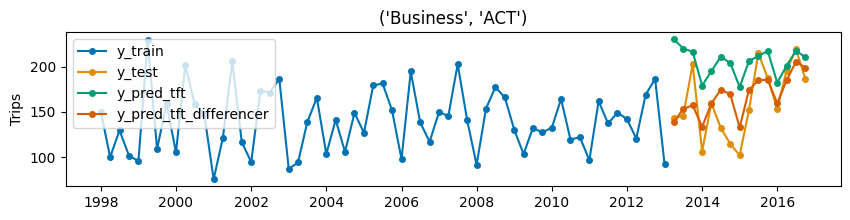

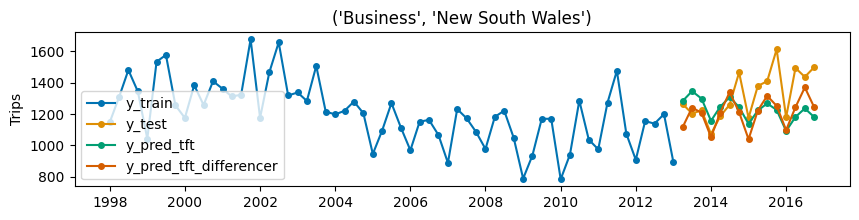

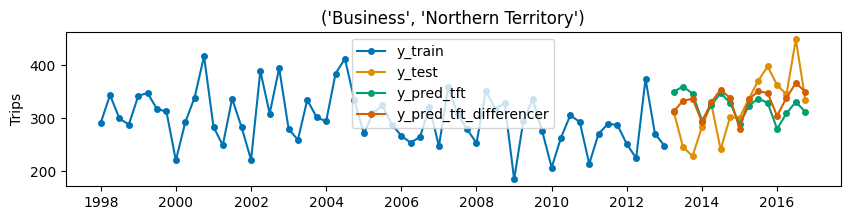

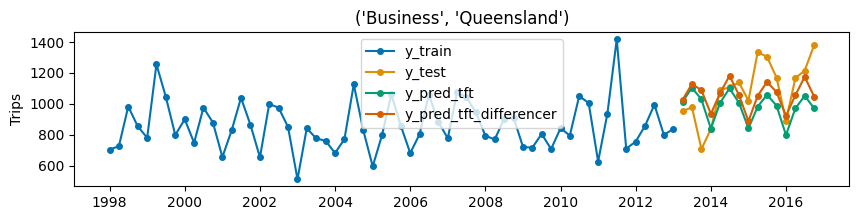

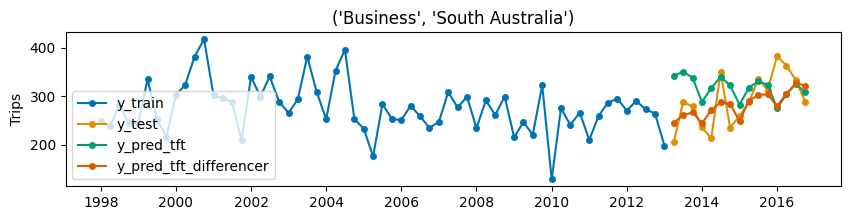

In [18]:
plot_series_and_forecast([y_pred_tft, y_pred_tft_differencer], ["y_pred_tft", "y_pred_tft_differencer"])
    

In [42]:
msse(
    y_true=y_test,
    y_pred=y_pred_tft,
    y_train=y_train,
), msse(
    y_true=y_test,
    y_pred=y_pred_tft_differencer,
    y_train=y_train,
)

(np.float64(1.9108318469903278), np.float64(2.609201276712622))

In [43]:
MeanSquaredScaledError(multilevel='raw_values')(
    y_true=y_test,
    y_pred=y_pred_tft_differencer,
    y_train=y_train,
)

MeanSquaredScaledError
Business ACT                               0.258408
         New South Wales                   0.595159
         Northern Territory                0.678388
         Queensland                        0.607829
         South Australia                   0.459301
         Victoria                          0.914517
         Western Australia                 8.556230
Holiday  ACT                               0.931616
         New South Wales                   0.740258
         Northern Territory                0.579579
         Queensland                       16.260177
         South Australia                   0.926962
         Victoria                          0.102063
         Western Australia                 1.979917
Other    ACT                               3.483330
         New South Wales                   3.020561
         Northern Territory                0.506172
         Queensland                        0.586532
         South Australia                   1.445502
         Victoria                          5.327950
         Western Australia                 1.810707
Visiting ACT                               3.064946
         New South Wales                   0.549327
         Northern Territory                2.979921
         Queensland                        3.669135
         South Australia                   1.976512
         Victoria                          6.368105
         Western Australia                 4.678533

In [20]:
y_pred_quantiles = tft_forecaster.predict_quantiles(X=X_test, fh=fh, alpha=[0.1, 0.5, 0.9])
y_pred_quantiles


/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

Trips                        
                                           0.1         0.5         0.9
Purpose  State             Quarter                                    
Business ACT               2013Q2    94.265625  230.387878  310.825745
                           2013Q3    80.754059  220.179016  299.794006
                           2013Q4    82.995560  216.558228  293.870728
                           2014Q1    65.302734  179.184082  251.079575
                           2014Q2    91.258705  195.125610  273.972046
...                                        ...         ...         ...
Visiting Western Australia 2015Q4   251.976700  525.127930  664.016724
                           2016Q1   238.902435  510.968201  644.115234
                           2016Q2   223.874435  419.825256  500.814514
                           2016Q3   216.500839  434.451294  524.272522
                           2016Q4   240.763123  469.705963  582.322388

[420 rows x 3 columns]

In [21]:
tft_forecaster.predict_interval(fh=fh, X=X_test, coverage=0.9)

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

Trips            
                                           0.9            
                                         lower       upper
Purpose  State             Quarter                        
Business ACT               2013Q2    47.132812  328.338562
                           2013Q3    40.377029  310.840576
                           2013Q4    41.497780  307.609192
                           2014Q1    32.651367  270.654938
                           2014Q2    45.629353  293.877380
...                                        ...         ...
Visiting Western Australia 2015Q4   125.988350  676.555542
                           2016Q1   119.451218  672.531738
                           2016Q2   111.937218  516.296265
                           2016Q3   108.250420  531.552063
                           2016Q4   120.381561  611.115479

[420 rows x 2 columns]

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

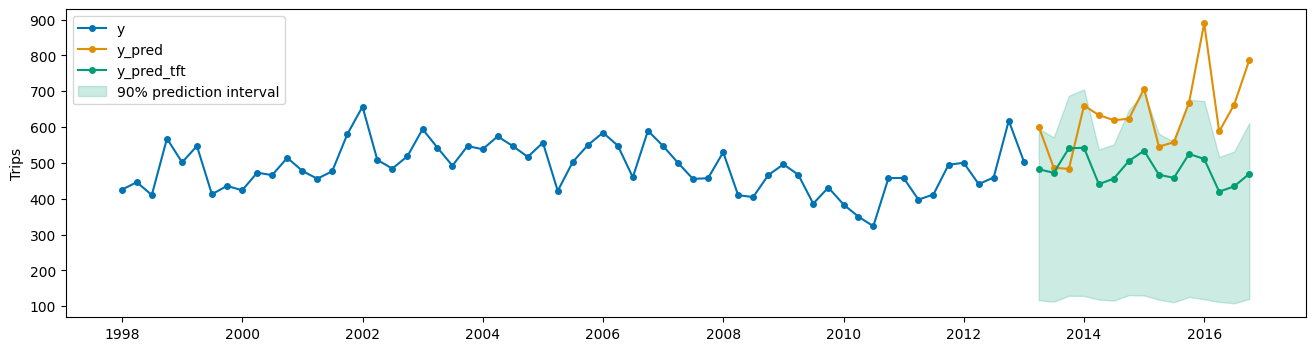

In [22]:
from sktime.utils import plotting

series = ("Visiting", "Western Australia")

fig, ax = plotting.plot_series(
    y_train.loc[series],
    y_test.loc[series],
    y_pred_tft.loc[series],
    labels=["y", "y_pred", "y_pred_tft"], pred_interval=tft_forecaster.predict_interval(
        X=X_test, fh=fh, coverage=0.9
    ).loc[series]
)

ax.legend()
fig.show()

#### DeepAR

* Autoregressive Recurrent networks
* Assumes a parametrized likelihood model. The network learns to predict the parameters of the distributions of the target variable.

![DeepAR](imgs/deepar.png)

In [23]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingDeepAR

deepar_forecaster =  PytorchForecastingDeepAR(
    
    model_params={
        "cell_type" : "LSTM",
        "rnn_layers" : 2,
        "hidden_size": 32,
        "learning_rate": 1e-3,
    },
    dataset_params={

        "max_encoder_length": CONTEXT_LENGTH,
    },
    trainer_params={
        "max_epochs": 100
        }

)

deepar_forecaster.fit(y_train, X=X_train, fh=fh)
y_pred_deepar = deepar_forecaster.predict(fh=fh, X=X_test) 

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["_target_column"].fillna(0, inplace=True)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                   | Type           

Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 17.87it/s, v_num=248, train_loss_step=5.720, val_loss=6.060, train_loss_epoch=5.670]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 17.35it/s, v_num=248, train_loss_step=5.720, val_loss=6.060, train_loss_epoch=5.670]


/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

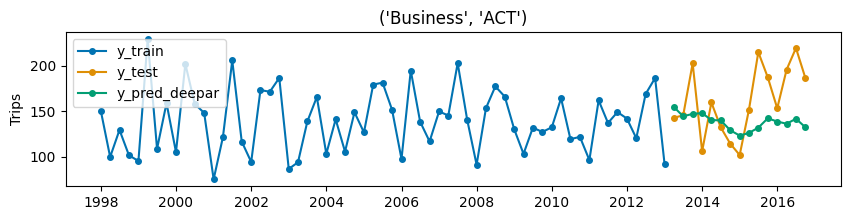

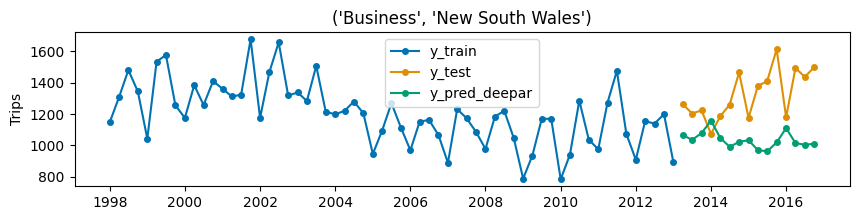

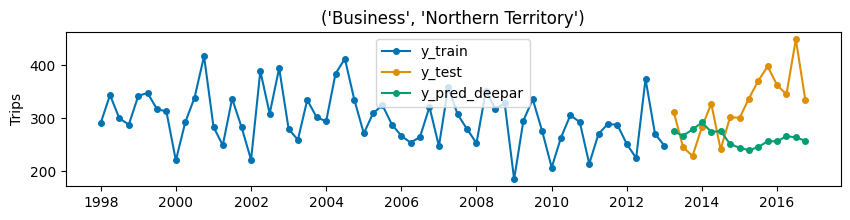

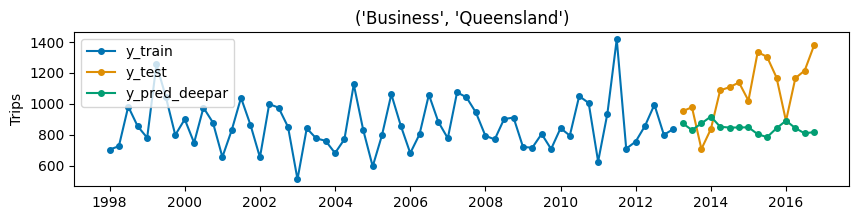

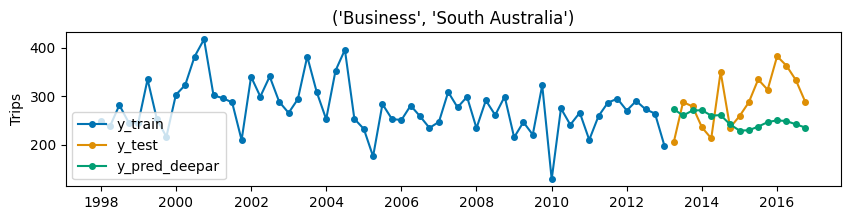

In [24]:
plot_series_and_forecast([ y_pred_deepar], [ "y_pred_deepar"])
    

In [25]:
deepar_differencer_forecaster = Differencer() * deepar_forecaster.clone()
deepar_differencer_forecaster.fit(y_train, X=X_train, fh=fh)
y_pred_deepar_differencer = deepar_differencer_forecaster.predict(fh=fh, X=X_test) 

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["_target_column"].fillna(0, inplace=True)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                   | Type           

Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 18.33it/s, v_num=250, train_loss_step=5.460, val_loss=6.170, train_loss_epoch=5.390]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 17.80it/s, v_num=250, train_loss_step=5.460, val_loss=6.170, train_loss_epoch=5.390]


/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

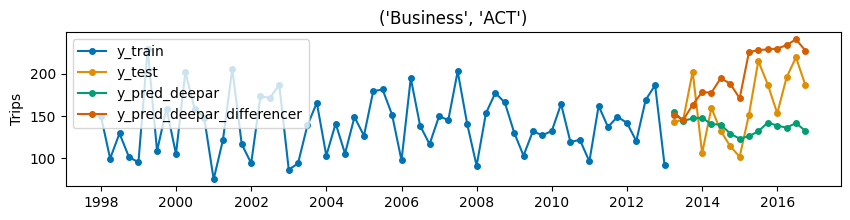

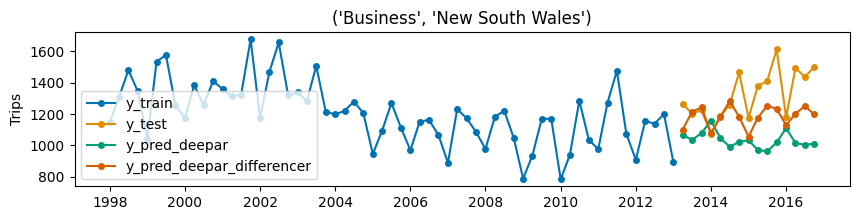

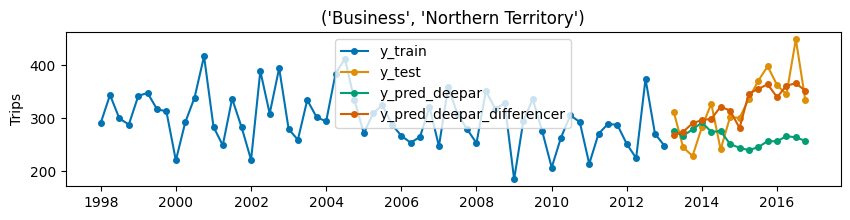

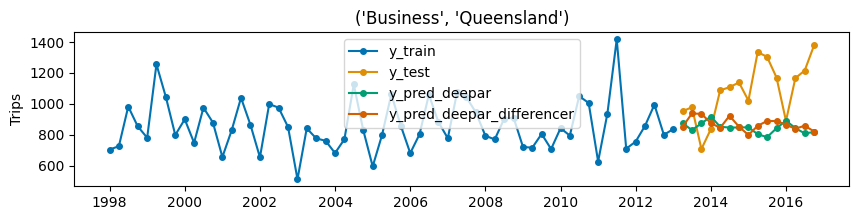

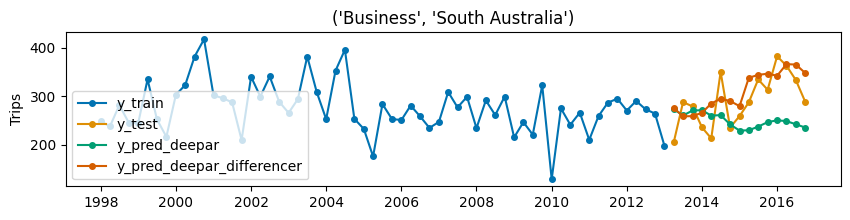

In [26]:
plot_series_and_forecast([y_pred_deepar, y_pred_deepar_differencer], ["y_pred_deepar", "y_pred_deepar_differencer"])

In [44]:
(msse(
    y_true=y_test,
    y_pred=y_pred_deepar,
    y_train=y_train,
), msse(
    y_true=y_test,
    y_pred=y_pred_deepar_differencer,
    y_train=y_train,
))

(np.float64(3.0063818907111823), np.float64(2.6589124242074793))

In [28]:
y_pred_interval = deepar_forecaster.predict_interval(
    X=X_test,
    fh=fh,
    coverage=0.9,
)
y_pred_interval

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

Trips            
                                           0.9            
                                         lower       upper
Purpose  State             Quarter                        
Business ACT               2013Q2    98.666389  189.586914
                           2013Q3   109.729416  179.591522
                           2013Q4   107.088043  198.131943
                           2014Q1    98.555107  192.852325
                           2014Q2    98.658485  176.215637
...                                        ...         ...
Visiting Western Australia 2015Q4   315.363892  577.261536
                           2016Q1   295.832916  642.317871
                           2016Q2   330.751648  572.331482
                           2016Q3   318.933990  575.093506
                           2016Q4   331.697083  544.889343

[420 rows x 2 columns]

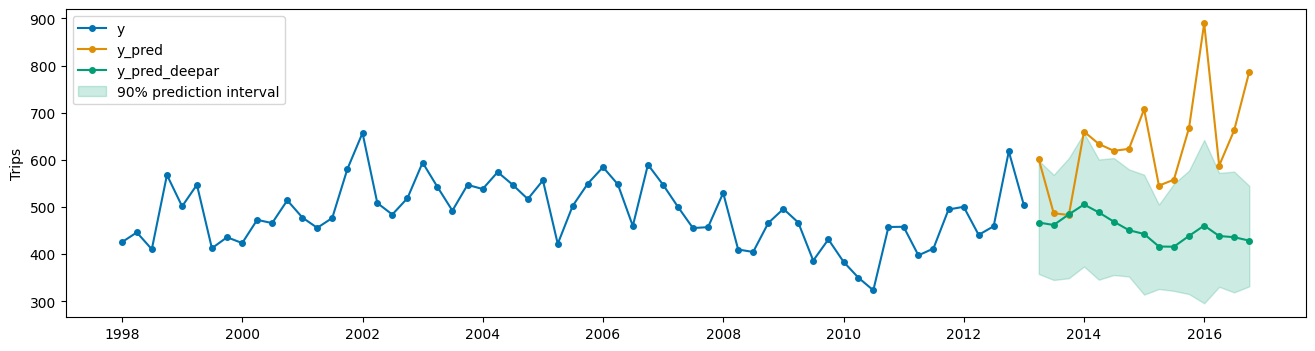

In [29]:

from sktime.utils import plotting


fig, ax = plotting.plot_series(
    y_train.loc[series],
    y_test.loc[series],
    y_pred_deepar.loc[series],
    labels=["y", "y_pred", "y_pred_deepar"], pred_interval=y_pred_interval.loc[series]
)

ax.legend()
fig.show()

## Forecasting unseen timeseries

* Most of global models can forecast unseen time series.
* Currently in sktime, this can be achieved by passing a context `y` to predict

In [30]:
from sktime.datasets import load_airline
y_new = load_airline().groupby(pd.Grouper(freq="Q")).sum()


y_train_new, y_test_new = temporal_train_test_split(y_new, test_size=TEST_SIZE) 
fh_new = y_test_new.index.get_level_values(-1)

/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_6804/1347703167.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  y_new = load_airline().groupby(pd.Grouper(freq="Q")).sum()
/var/folders/_2/9y4tsvdd2n3gqjgd2zmlr1km0000gn/T/ipykernel_6804/1347703167.py:2: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  y_new = load_airline().groupby(pd.Grouper(freq="Q")).sum()


/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

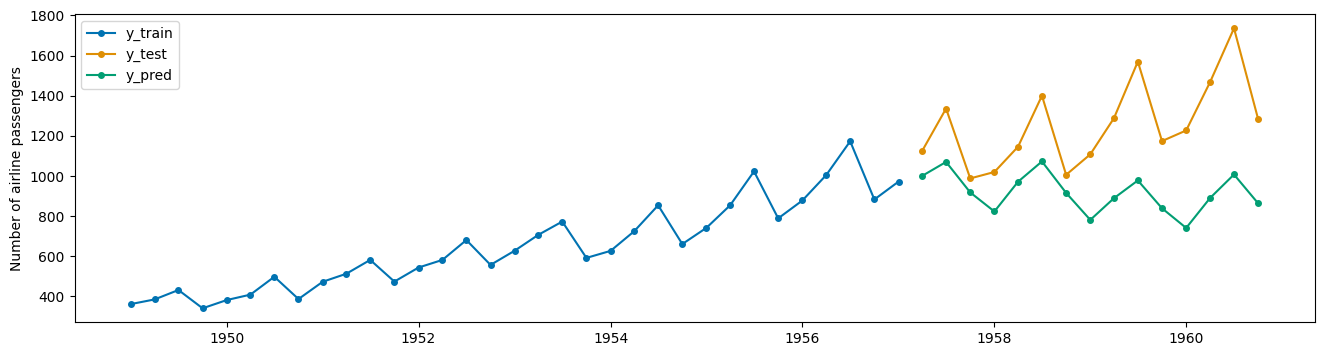

In [31]:
plot_series(
    y_train_new,
    y_test_new,
    nbeats_forecaster.predict(y=y_train_new),
    labels=["y_train", "y_test", "y_pred"],
)

Currently, the support for Pipelines with zero-shot forecasting is limited, but coming in future releases! For now, you could something like:

/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:655: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _y.fillna(0, inplace=True)
/Users/felipeangelim/Workspace/forecasting-course/.venv/lib/python3.11/site-packages/sktime/forecasting/base/adapters/_pytorchforecasting.py:509: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

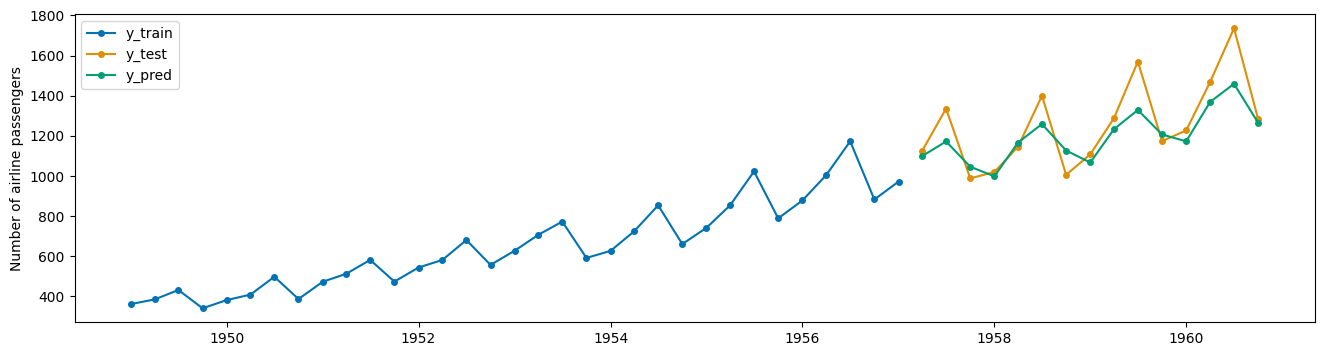

In [36]:
differencer = Differencer()
y_train_new_diff = differencer.fit_transform(y_train_new)


plot_series(
    y_train_new,
    y_test_new,
    differencer.inverse_transform(
        nbeats_differenced_forecaster.forecaster_.predict(
            y=y_train_new_diff,
        )
    ),
    labels=["y_train", "y_test", "y_pred"],
)

## Conclusions

* We have seen how to use deep learning for time-series forecasting, and how to use sktime to apply these models.
* We also have seen a general idea of how these models work: N-Beats, TFT and DeepAR.
* We saw how preprocessing can have an impact on the performance of these models.
* Forecasting unseen timeseries


## Extra: PyKAN


* Kolmogorov–Arnold Networks (KAN) is a new neural network architecture proposed in 2024.
* Instead of learning weights for fixed activation functions, **KANs learn the activation function**.

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.56e+01 | test_loss: 4.00e+01 | reg: 1.02e+02 | : 100%|█| 1/1 [00:00<00:00,  7.79it/s

saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0



| train_loss: 6.24e+00 | test_loss: 4.07e+01 | reg: 1.09e+02 | : 100%|█| 1/1 [00:00<00:00,  6.75it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.02e+02 | test_loss: 1.88e+02 | reg: 1.02e+02 | : 100%|█| 1/1 [00:00<00:00,  6.94it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.07e+01 | test_loss: 2.00e+02 | reg: 1.12e+02 | : 100%|█| 1/1 [00:00<00:00,  7.00it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.82e+01 | test_loss: 9.52e+01 | reg: 1.12e+02 | : 100%|█| 1/1 [00:00<00:00,  5.69it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.89e+01 | test_loss: 1.07e+02 | reg: 1.24e+02 | : 100%|█| 1/1 [00:00<00:00,  7.18it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.63e+01 | test_loss: 2.40e+02 | reg: 1.02e+02 | : 100%|█| 1/1 [00:00<00:00,  6.84it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.10e+01 | test_loss: 2.48e+02 | reg: 1.10e+02 | : 100%|█| 1/1 [00:00<00:00,  7.13it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.62e+01 | test_loss: 7.69e+01 | reg: 1.00e+02 | : 100%|█| 1/1 [00:00<00:00,  6.97it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.90e+01 | test_loss: 7.64e+01 | reg: 1.12e+02 | : 100%|█| 1/1 [00:00<00:00,  6.70it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.26e+01 | test_loss: 1.67e+02 | reg: 8.83e+01 | : 100%|█| 1/1 [00:00<00:00,  7.05it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.69e+01 | test_loss: 1.90e+02 | reg: 9.90e+01 | : 100%|█| 1/1 [00:00<00:00,  7.28it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.26e+01 | test_loss: 6.10e+01 | reg: 1.03e+02 | : 100%|█| 1/1 [00:00<00:00,  7.00it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.82e+01 | test_loss: 6.60e+01 | reg: 1.10e+02 | : 100%|█| 1/1 [00:00<00:00,  7.21it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.13e+01 | test_loss: 6.32e+01 | reg: 9.56e+01 | : 100%|█| 1/1 [00:00<00:00,  6.91it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e+01 | test_loss: 6.68e+01 | reg: 1.03e+02 | : 100%|█| 1/1 [00:00<00:00,  7.27it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.40e+02 | test_loss: 3.16e+02 | reg: 7.95e+01 | : 100%|█| 1/1 [00:00<00:00,  5.63it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.14e+02 | test_loss: 3.40e+02 | reg: 8.16e+01 | : 100%|█| 1/1 [00:00<00:00,  6.78it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e+02 | test_loss: 2.35e+02 | reg: 8.10e+01 | : 100%|█| 1/1 [00:00<00:00,  7.13it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.10e+02 | test_loss: 2.26e+02 | reg: 9.37e+01 | : 100%|█| 1/1 [00:00<00:00,  6.61it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.46e+02 | test_loss: 4.33e+02 | reg: 8.89e+01 | : 100%|█| 1/1 [00:00<00:00,  7.05it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.02e+02 | test_loss: 4.81e+02 | reg: 9.77e+01 | : 100%|█| 1/1 [00:00<00:00,  6.86it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.78e+01 | test_loss: 1.13e+02 | reg: 9.26e+01 | : 100%|█| 1/1 [00:00<00:00,  7.03it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.50e+01 | test_loss: 1.55e+02 | reg: 9.96e+01 | : 100%|█| 1/1 [00:00<00:00,  6.88it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.71e+01 | test_loss: 2.09e+02 | reg: 8.01e+01 | : 100%|█| 1/1 [00:00<00:00,  7.03it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.76e+01 | test_loss: 2.09e+02 | reg: 7.96e+01 | : 100%|█| 1/1 [00:00<00:00,  6.87it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.72e+01 | test_loss: 9.40e+01 | reg: 9.69e+01 | : 100%|█| 1/1 [00:00<00:00,  7.15it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.58e+01 | test_loss: 1.02e+02 | reg: 1.10e+02 | : 100%|█| 1/1 [00:00<00:00,  6.24it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.45e+00 | test_loss: 1.94e+01 | reg: 1.12e+02 | : 100%|█| 1/1 [00:00<00:00,  7.01it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.16e-01 | test_loss: 1.88e+01 | reg: 1.17e+02 | : 100%|█| 1/1 [00:00<00:00,  6.92it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.60e+01 | test_loss: 7.48e+01 | reg: 9.93e+01 | : 100%|█| 1/1 [00:00<00:00,  7.02it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.31e+00 | test_loss: 9.15e+01 | reg: 1.11e+02 | : 100%|█| 1/1 [00:00<00:00,  7.27it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.53e+01 | test_loss: 3.41e+01 | reg: 1.13e+02 | : 100%|█| 1/1 [00:00<00:00,  6.70it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.77e+01 | test_loss: 4.42e+01 | reg: 1.31e+02 | : 100%|█| 1/1 [00:00<00:00,  7.18it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.54e+01 | test_loss: 5.82e+01 | reg: 9.61e+01 | : 100%|█| 1/1 [00:00<00:00,  6.97it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.45e+01 | test_loss: 6.25e+01 | reg: 1.16e+02 | : 100%|█| 1/1 [00:00<00:00,  7.06it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.00e+00 | test_loss: 1.97e+01 | reg: 9.74e+01 | : 100%|█| 1/1 [00:00<00:00,  7.18it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.27e+00 | test_loss: 2.11e+01 | reg: 1.01e+02 | : 100%|█| 1/1 [00:00<00:00,  7.29it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.40e+01 | test_loss: 4.61e+01 | reg: 9.14e+01 | : 100%|█| 1/1 [00:00<00:00,  7.33it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.67e+01 | test_loss: 5.23e+01 | reg: 9.69e+01 | : 100%|█| 1/1 [00:00<00:00,  7.33it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.91e+01 | test_loss: 1.54e+01 | reg: 8.88e+01 | : 100%|█| 1/1 [00:00<00:00,  7.26it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.17e+01 | test_loss: 1.62e+01 | reg: 9.69e+01 | : 100%|█| 1/1 [00:00<00:00,  6.29it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.97e+01 | test_loss: 1.98e+01 | reg: 9.69e+01 | : 100%|█| 1/1 [00:00<00:00,  7.21it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.06e+01 | test_loss: 2.14e+01 | reg: 1.03e+02 | : 100%|█| 1/1 [00:00<00:00,  7.40it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.48e+02 | test_loss: 2.73e+02 | reg: 8.09e+01 | : 100%|█| 1/1 [00:00<00:00,  7.03it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.88e+01 | test_loss: 3.30e+02 | reg: 8.72e+01 | : 100%|█| 1/1 [00:00<00:00,  6.97it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.06e+01 | test_loss: 1.08e+02 | reg: 9.89e+01 | : 100%|█| 1/1 [00:00<00:00,  7.27it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.59e+01 | test_loss: 1.15e+02 | reg: 1.13e+02 | : 100%|█| 1/1 [00:00<00:00,  6.75it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.54e+01 | test_loss: 2.71e+02 | reg: 1.05e+02 | : 100%|█| 1/1 [00:00<00:00,  7.09it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.50e+01 | test_loss: 3.02e+02 | reg: 1.14e+02 | : 100%|█| 1/1 [00:00<00:00,  6.99it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.20e+01 | test_loss: 9.45e+01 | reg: 1.05e+02 | : 100%|█| 1/1 [00:00<00:00,  6.98it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.27e+01 | test_loss: 9.97e+01 | reg: 1.09e+02 | : 100%|█| 1/1 [00:00<00:00,  6.64it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.57e+01 | test_loss: 1.67e+02 | reg: 9.79e+01 | : 100%|█| 1/1 [00:00<00:00,  7.18it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.42e+01 | test_loss: 1.66e+02 | reg: 1.03e+02 | : 100%|█| 1/1 [00:00<00:00,  7.34it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.67e+01 | test_loss: 9.45e+01 | reg: 8.75e+01 | : 100%|█| 1/1 [00:00<00:00,  5.95it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.01e+01 | test_loss: 9.44e+01 | reg: 1.02e+02 | : 100%|█| 1/1 [00:00<00:00,  7.49it/s


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: 

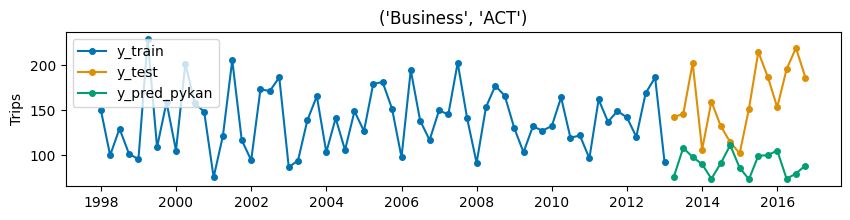

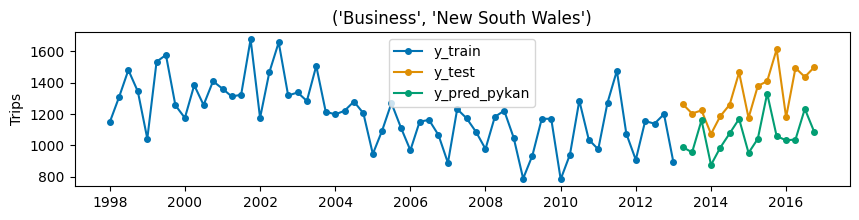

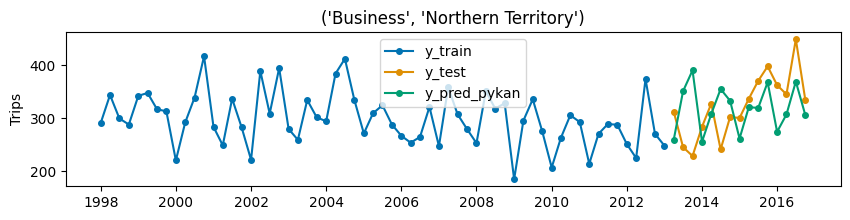

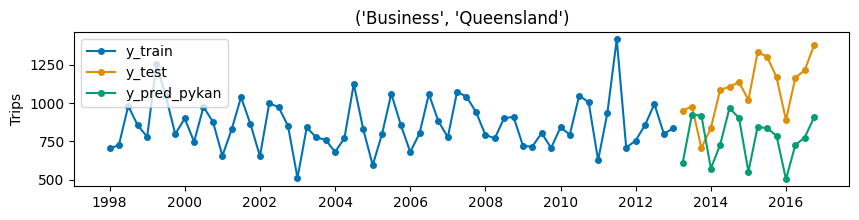

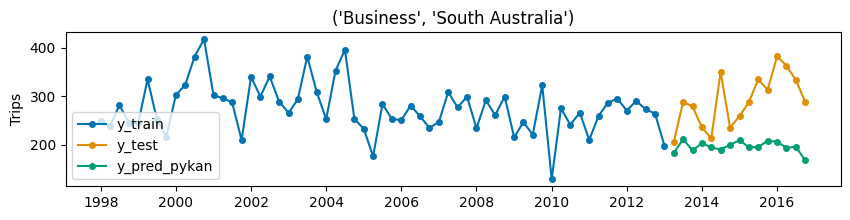

In [37]:
pykan_forecaster = Differencer() * PyKANForecaster(
    hidden_layers=(10, 10), input_layer_size=8
)
pykan_forecaster.fit(y_train, X=X_train, fh=fh)

# Predict
y_pred_pykan = pykan_forecaster.predict(fh=fh, X=X_test)

# Plot
plot_series_and_forecast([y_pred_pykan], ["y_pred_pykan"])

In [49]:
msse(
    y_true=y_test,
    y_pred=y_pred_pykan,
    y_train=y_train,
)

np.float64(3.242987291382132)